In [21]:
import json
from pathlib import Path
from typing import List, Dict, Any, TypedDict
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

load_dotenv()

llm = ChatGroq(temperature=0, model_name="llama-3.1-8b-instant")

In [8]:
class ResumeStructured(BaseModel):
    name: str
    contact: Dict[str, str]
    skills: List[str]
    work_experience: List[Dict[str, str]]
    education: List[Dict[str, str]]
    years_experience: float


class NormalizedResume(BaseModel):
    source_file: str
    name: str
    skills: List[str]
    qualification: str
    years_experience: float


class JobRequirements(BaseModel):
    required_skills: List[str]
    min_degree: str
    years_required: float


class CandidateScore(BaseModel):
    source_file: str
    name: str
    experience_score: float
    qualification_score: float
    skills_score: float
    final_score: float
    breakdown: Dict[str, Any]


class WorkflowState(TypedDict, total=False):
    job_description_path: str
    resume_file_paths: List[str]
    job_requirements: JobRequirements
    structured_resumes: List[Dict[str, Any]]
    normalized_resumes: List[NormalizedResume]
    scored_candidates: List[CandidateScore]
    final_report: Dict[str, Any]

In [9]:
def parse_job_description(state: WorkflowState) -> Dict[str, Any]:
    jd_text = Path(state["job_description_path"]).read_text()

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "Extract job requirements in JSON format with required_skills (list), min_degree (string), and years_required (number).",
            ),
            ("human", "{jd_text}"),
        ]
    )

    chain = prompt | llm.with_structured_output(JobRequirements)
    job_requirements = chain.invoke({"jd_text": jd_text})

    print(
        f"✓ Parsed job requirements: {len(job_requirements.required_skills)} skills, {job_requirements.years_required} years required"
    )

    return {"job_requirements": job_requirements}

In [10]:
def extract_resume_structure(state: WorkflowState) -> Dict[str, Any]:
    structured_resumes = []

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """Extract resume information into JSON format with:
                    - name (string)
                    - contact (dict with email, phone if available)
                    - skills (list of strings)
                    - work_experience (list of dicts with company, position, duration)
                    - education (list of dicts with degree, institution)
                    - years_experience (float, total years of work experience)""",
            ),
            ("human", "{resume_text}"),
        ]
    )

    chain = prompt | llm.with_structured_output(ResumeStructured)

    for file_path_str in state["resume_file_paths"]:
        file_path = Path(file_path_str)
        resume_text = file_path.read_text()

        structured = chain.invoke({"resume_text": resume_text})
        structured_resumes.append({"source_file": file_path.name, "data": structured})
        print(f"✓ Extracted structure from {file_path.name}")

    return {"structured_resumes": structured_resumes}

In [11]:
def normalize_resumes(state: WorkflowState) -> Dict[str, Any]:
    normalized_resumes = []

    degree_mapping_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                """Map the degree to one of these categories:
                    - Computer Engineering
                    - CSIT
                    - BIT
                    - BBS
                    - Others
                    Return only the category name.""",
            ),
            ("human", "Degree: {degree}"),
        ]
    )

    chain = degree_mapping_prompt | llm

    for item in state["structured_resumes"]:
        resume = item["data"]

        degree_text = resume.education[0]["degree"] if resume.education else "Unknown"
        mapped_degree = chain.invoke({"degree": degree_text})
        qualification = (
            mapped_degree.content.strip()
            if hasattr(mapped_degree, "content")
            else str(mapped_degree).strip()
        )

        normalized = NormalizedResume(
            source_file=item["source_file"],
            name=resume.name,
            skills=resume.skills,
            qualification=qualification,
            years_experience=resume.years_experience,
        )
        normalized_resumes.append(normalized)
        print(
            f"✓ Normalized {resume.name}: {qualification}, {resume.years_experience} years"
        )

    return {"normalized_resumes": normalized_resumes}

In [12]:
def score_candidates(state: WorkflowState) -> Dict[str, Any]:
    job_req = state["job_requirements"]
    scored_candidates = []

    degree_weights = {
        "Computer Engineering": 10,
        "CSIT": 9,
        "BIT": 8,
        "BBS": 4,
        "Others": 5,
    }

    required_skills_set = set(s.lower().strip() for s in job_req.required_skills)

    for resume in state["normalized_resumes"]:
        exp_score = (
            min((resume.years_experience / job_req.years_required) * 10, 10)
            if job_req.years_required > 0
            else 0
        )

        qual_score = degree_weights.get(resume.qualification, 5)

        candidate_skills_set = set(s.lower().strip() for s in resume.skills)
        matched_skills = required_skills_set & candidate_skills_set
        skills_score = (
            (len(matched_skills) / len(required_skills_set)) * 10
            if required_skills_set
            else 0
        )

        final_score = round((exp_score + qual_score + skills_score) / 3, 2)

        scored = CandidateScore(
            source_file=resume.source_file,
            name=resume.name,
            experience_score=round(exp_score, 2),
            qualification_score=round(qual_score, 2),
            skills_score=round(skills_score, 2),
            final_score=final_score,
            breakdown={
                "years_experience": resume.years_experience,
                "qualification": resume.qualification,
                "matched_skills": sorted(list(matched_skills)),
                "total_required_skills": len(required_skills_set),
            },
        )
        scored_candidates.append(scored)
        print(f"✓ Scored {resume.name}: {final_score}/10")

    return {"scored_candidates": scored_candidates}

In [13]:
def generate_report(state: WorkflowState) -> Dict[str, Any]:
    scored = sorted(
        state["scored_candidates"], key=lambda x: x.final_score, reverse=True
    )

    shortlisted = [c for c in scored if c.final_score >= 7.0]
    rejected = [c for c in scored if c.final_score < 7.0]

    report = {
        "shortlisted_candidates": [c.model_dump() for c in shortlisted],
        "rejected_candidates": [c.model_dump() for c in rejected],
    }

    Path("shortlist_report.json").write_text(json.dumps(report, indent=2))
    print(
        f"✓ Generated report: {len(shortlisted)} shortlisted, {len(rejected)} rejected"
    )

    return {"final_report": report}

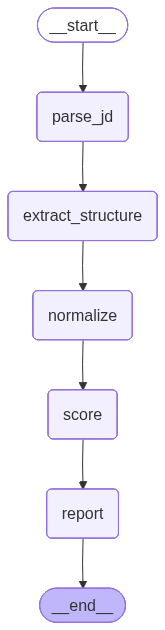

In [22]:
workflow = StateGraph(WorkflowState)

workflow.add_node("parse_jd", parse_job_description)
workflow.add_node("extract_structure", extract_resume_structure)
workflow.add_node("normalize", normalize_resumes)
workflow.add_node("score", score_candidates)
workflow.add_node("report", generate_report)

workflow.set_entry_point("parse_jd")
workflow.add_edge("parse_jd", "extract_structure")
workflow.add_edge("extract_structure", "normalize")
workflow.add_edge("normalize", "score")
workflow.add_edge("score", "report")
workflow.add_edge("report", END)

app = workflow.compile()
graph_image = app.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [15]:
inputs = {
    "job_description_path": "job_description.txt",
    "resume_file_paths": [
        "resumes/candidate_aashish.txt",
        "resumes/candidate_sampada.txt",
    ],
}

result = app.invoke(inputs)

report = result["final_report"]
report

✓ Parsed job requirements: 7 skills, 4.0 years required
✓ Extracted structure from candidate_aashish.txt
✓ Extracted structure from candidate_sampada.txt
✓ Normalized Aashish Thapa: Computer Engineering, 6.0 years
✓ Normalized Sampada Poudel: CSIT, 1.5 years
✓ Scored Aashish Thapa: 9.05/10
✓ Scored Sampada Poudel: 4.73/10
✓ Generated report: 1 shortlisted, 1 rejected


{'shortlisted_candidates': [{'source_file': 'candidate_aashish.txt',
   'name': 'Aashish Thapa',
   'experience_score': 10.0,
   'qualification_score': 10.0,
   'skills_score': 7.14,
   'final_score': 9.05,
   'breakdown': {'years_experience': 6.0,
    'qualification': 'Computer Engineering',
    'matched_skills': ['django rest framework',
     'docker',
     'git',
     'postgresql',
     'python'],
    'total_required_skills': 7}}],
 'rejected_candidates': [{'source_file': 'candidate_sampada.txt',
   'name': 'Sampada Poudel',
   'experience_score': 3.75,
   'qualification_score': 9.0,
   'skills_score': 1.43,
   'final_score': 4.73,
   'breakdown': {'years_experience': 1.5,
    'qualification': 'CSIT',
    'matched_skills': ['git'],
    'total_required_skills': 7}}]}